# Convolutional Neural Network and Adversarial Attacks

En el siguiente código se crea una red neuronal convolucional que identifica dígitos escritos a mano para posteriormente engañarla usando un white box adversarial attack conocido como FGSM

# Importaciones

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from random import randrange

# Dataset

A continuación descargamos el dataset

In [2]:
#  Cargamos el dataset y lo dividimos en entrenamiento y entreno
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Importante: normalizar los píxeles entre 0 y 1. También se puede usar el método normalize
train_images, test_images = train_images / 255.0, test_images / 255.0

## Comprobamos el formato

Elegimos una imagen y mostramos su imagen y su etiqueta

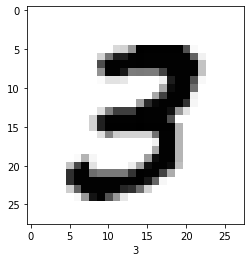

In [3]:
num_imagen = 7  

plt.imshow(train_images[num_imagen] ,cmap=plt.cm.binary)
plt.xlabel(train_labels[num_imagen])
plt.show()

## Reshape
La red espera una entrada de la forma (60000, 28, 28, 1), de forma que tenemos que modificar la entrada a eso

In [4]:
train_images = train_images.reshape(60000,28,28,1)
test_images = test_images.reshape(10000,28,28,1)

# Definición de la red

In [5]:
# Creamos un modelo secuencial, es decir, la información fluirá de izquierda a derecha
model = models.Sequential()

# Añadimos las capas convolucionaes
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Y posteriormente, las pasamos a capas lineales
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu')) # Que escojamos 64 neuronas no tiene nada que ver con lo anterior
model.add(layers.Dense(10, activation='softmax'))

# Echemos un vistazo a cómo nos queda la red
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Creación de la red

In [6]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

## Entrenamiento de la red

In [7]:
entrenamiento = model.fit(train_images, train_labels, epochs=3, validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 6s 106us/sample - loss: 0.1455 - accuracy: 0.9545 - val_loss: 0.0735 - val_accuracy: 0.9767
Epoch 2/3
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0462 - accuracy: 0.9853 - val_loss: 0.0324 - val_accuracy: 0.9893
Epoch 3/3
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0340 - accuracy: 0.9894 - val_loss: 0.0336 - val_accuracy: 0.9886


## Análisis de resultados

Comprobamos ahora en función de los datos de pérdida y precisión si sería beneficial aumentar las épocas o no

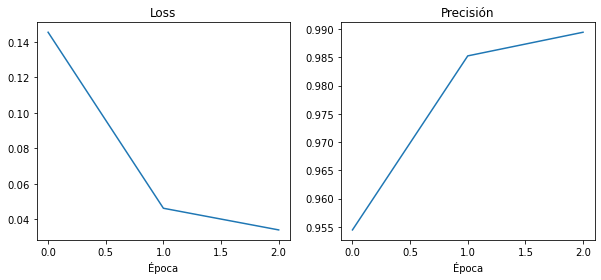

In [8]:
# Mostramos la pérdida y la precisión
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title("Loss")
plt.xlabel("Época")
plt.plot(entrenamiento.history['loss'], label= "Loss")

plt.subplot(122)
plt.title("Precisión")
plt.xlabel("Época")
plt.plot(entrenamiento.history['accuracy'], label= "Precisión")

En base a la gráfica se observa que el valor ideal de épocas es 3 (empezamos en 0)

# Testeo de la red

En este caso, el modelo comprueba en cada época la precisión con los datos de test, de forma que aumenta de forma más rápida la precisión. Es decir, la siguiente parte daría el mismo resultado que la última época de entrenamiento. Esto sólo tendrá sentido cuando metamos el adversarial dataset

In [9]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)

10000/10000 [==============================] - 0s 48us/sample - loss: 0.0336 - accuracy: 0.9886


# Predicción de resultados

Comprobamos que las imágenes introducidas corresponden con los valores predichos


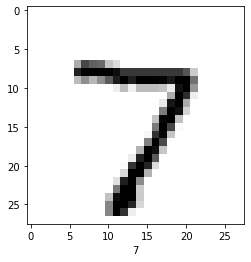

La clase predicha es: 7 con una confianza del 100.0 %


In [10]:
num_imagen = 0

plt.imshow(test_images[num_imagen], cmap=plt.cm.binary)
plt.xlabel(test_labels[num_imagen])
plt.show()

print("La clase predicha es:", np.argmax(model.predict([test_images])[num_imagen]), "con una confianza del", 
      round(np.max(model.predict([test_images])[num_imagen])*100, 2), "%")

# Crear dataset FGSM
### Crear las perturbaciones
Primero calculamos las perturbaciones para el dataset escogido, de forma que podemos realizar el FGSM sobre el test para realizar pruebas o sobre el train para entrenar posteriormente a la red con él

In [16]:
# Introducimos el dataset del que queremos imágenes adversariales. De momento es test, luego ya en la defensa pondremos train
dataset = "test"
   
perturbaciones_testset = FGSM(dataset)

### Creación de las adversarial images
Una vez tenemos las perturbaciones del dataset escogido, lo recorremos para los valores de epsilon deseados obteniendo un vector de predicciones

In [20]:
# Definimos los valores de epsilon para los que queremos crear el dataset
epsilon = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])

# Creamos nuestro vector vacío con las predicciones
predicciones = np.empty([len(epsilon), 10000, 10])

# Creamos nuestro vector vacío que contendrá el testset
adversarial_testset = np.empty([len(epsilon), 10000, 28, 28, 1])
            
# Recorremos los datasets para cada uno de esos valores de epsilon    
for i in range(len(epsilon)):
    # Creamos el adversarial dataset
    adversarial_testset[i] = creacion_adversarial_dataset(epsilon[i], dataset, perturbaciones_testset)   

    # Calculamos las métricas
    predicciones[i] = model.predict([adversarial_testset[i]])

(8, 10000, 28, 28, 1)


### Comprobación de que se han creado correctamente

La forma del vector predicciones es: (8, 10000, 10)
La forma del adversarial testset es: (8, 10000, 28, 28, 1)
La predicción es: 2 con una confianza del 50.999999046325684 %


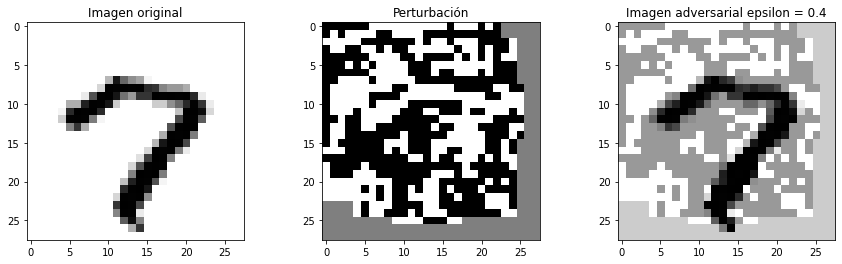

In [32]:
# Mostramos la forma
print("La forma del vector predicciones es:", predicciones.shape)
print("La forma del adversarial testset es:", adversarial_testset.shape)
    
# Imprimimos una imagen aleatoria con un valor de epsilon aleatorio
num_imagen = randrange(10000)
valor = randrange(len(epsilon))
    
imagen_original = test_images[num_imagen]
perturbacion = perturbaciones_testset[num_imagen] * 0.5 + 0.5
imagen = adversarial_testset[valor][num_imagen]
    
# Llamamos a la funciones de impresión y predicción
impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilon[valor])
prediccion_adversarial(imagen)

# Análisis de métricas

Para epsilon = 0.01: Aciertos = 9867, Fallos = 133 luego Precisión = 98.67 % con una confianza media del 98.89 %
Para epsilon = 0.05: Aciertos = 9737, Fallos = 263 luego Precisión = 97.37 % con una confianza media del 97.97 %
Para epsilon = 0.1: Aciertos = 9482, Fallos = 518 luego Precisión = 94.82 % con una confianza media del 96.26 %
Para epsilon = 0.15: Aciertos = 9050, Fallos = 950 luego Precisión = 90.50 % con una confianza media del 93.31 %
Para epsilon = 0.2: Aciertos = 8373, Fallos = 1627 luego Precisión = 83.73 % con una confianza media del 89.42 %
Para epsilon = 0.3: Aciertos = 6349, Fallos = 3651 luego Precisión = 63.49 % con una confianza media del 79.11 %
Para epsilon = 0.4: Aciertos = 4155, Fallos = 5845 luego Precisión = 41.55 % con una confianza media del 69.97 %
Para epsilon = 0.5: Aciertos = 2616, Fallos = 7384 luego Precisión = 26.16 % con una confianza media del 64.67 %


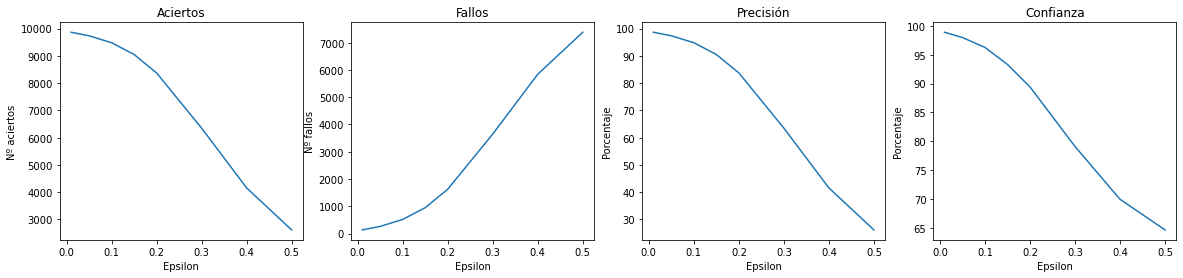

In [26]:
# Creamos los vectores globales
aciertos_epsilon = np.empty(len(epsilon)) 
fallos_epsilon = np.empty(len(epsilon))
precisiones = np.empty(len(epsilon))
confianzas = np.empty(len(epsilon)) 

# Recorremos los epsilons
for i in range(len(epsilon)):
    aciertos = 0
    confianza = 0
    
    # Recorremos las predicciones
    for j in range(10000):
        prediccion = np.argmax(predicciones[i][j])
        confianza = confianza + np.max(predicciones[i][j])
        if prediccion == test_labels[j]:
            aciertos += 1
     
    # Calculamos las métricas para cada epsilon
    fallos = 10000 - aciertos
    precision = (aciertos / 10000) * 100
    confianza = (confianza / 10000) * 100
    print("Para epsilon = {}: Aciertos = {}, Fallos = {} luego Precisión = {:0.2f} % con una confianza media del {:0.2f} %"
          . format(epsilon[i], aciertos, fallos, precision, confianza))
    
    # Creamos un vector con todas las métricas para poder realizar gráficas
    aciertos_epsilon[i] = aciertos
    fallos_epsilon[i] = fallos
    precisiones[i] = precision
    confianzas[i] = confianza
    
# Creamos gráficas de los resultados
plt.figure(figsize=(20,4))

plt.subplot(141)
plt.title("Aciertos")
plt.xlabel("Epsilon")
plt.ylabel("Nº aciertos")
plt.plot(epsilon, aciertos_epsilon)

plt.subplot(142)
plt.title("Fallos")
plt.xlabel("Epsilon")
plt.ylabel("Nº fallos")
plt.plot(epsilon, fallos_epsilon)

plt.subplot(143)
plt.title("Precisión")
plt.xlabel("Epsilon")
plt.ylabel("Porcentaje")
plt.plot(epsilon, precisiones)

plt.subplot(144)
plt.title("Confianza")
plt.xlabel("Epsilon")
plt.ylabel("Porcentaje")
plt.plot(epsilon, confianzas)

# Defensa frente a ataques adversariales
A continuación tenemos que realizar un proceso muy parecido al anterior pero ahora con el trainset, de forma que obtendremos 60000 imágenes adversariales para el valor o valores de epsilon especificados. Esas imágenes las añadiremos al dataset inicial y entrenaremos a nuestra red con los conjuntos originales y los adversariales de forma que la precisión debería volver a subir

### Creación de las perturbaciones del trainset

In [27]:
dataset = "train"
   
perturbaciones_trainset = FGSM(dataset)

### Creación del trainset adversarial

In [33]:
# Definimos los valores de epsilon para los que queremos crear el dataset
# Tarda un huevo, así que, de momento, preferiblemente sólo 1. Pongo 0.4 porque es el que hace que sea básicamente random
epsilon = np.array([0.4])

# Creamos nuestro vector vacío que contrendrá el dataset
adversarial_trainset = np.empty([len(epsilon), 60000, 28, 28, 1])
            
# Recorremos los datasets para cada uno de esos valores de epsilon    
for i in range(len(epsilon)):
    # Creamos el adversarial dataset
    adversarial_trainset[i] = creacion_adversarial_dataset(epsilon[i], dataset, perturbaciones_trainset)   

### Comprobación de que se ha creado correctamente

La forma del adversarial trainset es: (1, 60000, 28, 28, 1)


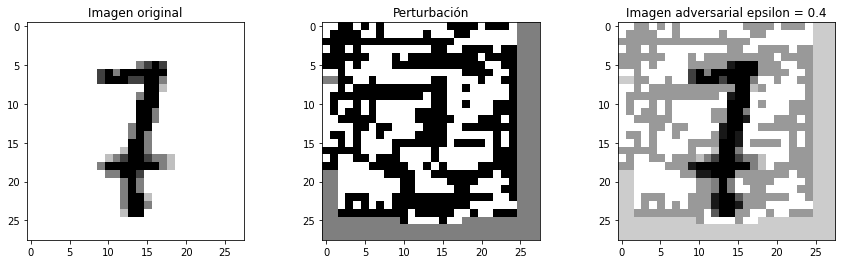

In [34]:
# Mostramos la forma
print("La forma del adversarial trainset es:", adversarial_trainset.shape)
    
# Imprimimos una imagen aleatoria con un valor de epsilon aleatorio
valor = randrange(len(epsilon))
num_imagen = randrange(10000)

imagen_original = train_images[num_imagen]
perturbacion = perturbaciones_trainset[num_imagen]
imagen = adversarial_trainset[valor][num_imagen]

# Llamamos a la funciones de impresión y predicción
impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilon[valor])

### Creación del nuevo conjunto de entrenamiento y test con las imágenes adversariales
Hasta ahora tenemos nuestro adversarial trainset y el adversarial dataset. Ahora tenemos que definir qué imágenes queremos de dentro de esos conjuntos, así como establecer sus correctas etiquetas para entrenar posteriormente la red

In [36]:
# Creación del conjunto de entrenamiento
# Lo inicializamos con las imágenes originales
trainset_defensa = train_images
trainset_defensa_labels = train_labels

# Y vamos añadiendo los epsilons establecidos, aunque típicamente será sólo 1
for i in range(len(epsilon)):
    trainset_defensa = np.concatenate((trainset_defensa, adversarial_trainset[i]))
    trainset_defensa_labels = np.concatenate((trainset_defensa_labels, train_labels))

# Imprimimos las formas para comprobar que son las correctas
print(trainset_defensa.shape)
print(trainset_defensa_labels.shape)

(120000, 28, 28, 1)
(120000,)


In [39]:
# Creación del conjunto de test. Lo creamos para los mismos epsilons
testset_defensa = test_images
testset_defensa_labels = test_labels

# Y vamos añadiendo el testset que corresponde al mismo valor de epsilon que en el caso anterior, que es la posición 6
posicion_epsilon = 6
testset_defensa = np.concatenate((testset_defensa, adversarial_testset[posicion_epsilon]))
testset_defensa_labels = np.concatenate((testset_defensa_labels, test_labels))

# Imprimimos las formas para comprobar que son las correctas
print(testset_defensa.shape)
print(testset_defensa_labels.shape)


(20000, 28, 28, 1)
(20000,)


### Entrenamiento del modelo con el nuevo dataset adversarial

In [40]:
entrenamiento = model.fit(trainset_defensa, trainset_defensa_labels, epochs=3, validation_data=(testset_defensa, testset_defensa_labels))

Train on 120000 samples, validate on 20000 samples
Epoch 1/3
120000/120000 [==============================] - 9s 77us/sample - loss: 0.0504 - accuracy: 0.9842 - val_loss: 0.0369 - val_accuracy: 0.9885
Epoch 2/3
120000/120000 [==============================] - 9s 77us/sample - loss: 0.0196 - accuracy: 0.9940 - val_loss: 0.0241 - val_accuracy: 0.9926
Epoch 3/3
120000/120000 [==============================] - 9s 76us/sample - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0225 - val_accuracy: 0.9936


### Cálculo de las nuevas predicciones del modelo

In [42]:
# Definimos los mismos epsilons que antes
epsilon = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])

# Creamos nuestro vector vacío con las predicciones
predicciones = np.empty([len(epsilon), 10000, 10])
        
# Recorremos los datasets para cada uno de esos valores de epsilon    
for i in range(len(epsilon)):
    
    # Calculamos las métricas
    predicciones[i] = model.predict([adversarial_testset[i]])

### Análisis de métricas con el nuevo modelo
Repetimos los pasos anteriores para comprobar si efectivamente hemos mejorado la precisión

Para epsilon = 0.01: Aciertos = 9910, Fallos = 90 luego Precisión = 99.10 % con una confianza media del 99.55 %
Para epsilon = 0.05: Aciertos = 9924, Fallos = 76 luego Precisión = 99.24 % con una confianza media del 99.64 %
Para epsilon = 0.1: Aciertos = 9937, Fallos = 63 luego Precisión = 99.37 % con una confianza media del 99.69 %
Para epsilon = 0.15: Aciertos = 9950, Fallos = 50 luego Precisión = 99.50 % con una confianza media del 99.71 %
Para epsilon = 0.2: Aciertos = 9958, Fallos = 42 luego Precisión = 99.58 % con una confianza media del 99.73 %
Para epsilon = 0.3: Aciertos = 9964, Fallos = 36 luego Precisión = 99.64 % con una confianza media del 99.73 %
Para epsilon = 0.4: Aciertos = 9963, Fallos = 37 luego Precisión = 99.63 % con una confianza media del 99.72 %
Para epsilon = 0.5: Aciertos = 9934, Fallos = 66 luego Precisión = 99.34 % con una confianza media del 99.45 %


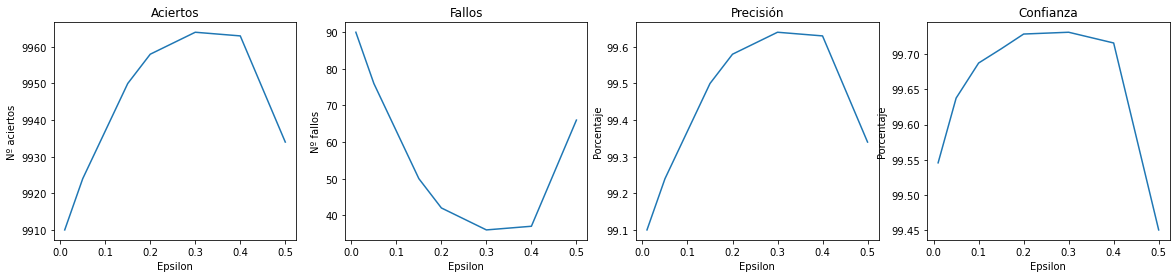

In [43]:
# Creamos los vectores globales
aciertos_epsilon = np.empty(len(epsilon)) 
fallos_epsilon = np.empty(len(epsilon))
precisiones = np.empty(len(epsilon))
confianzas = np.empty(len(epsilon)) 

# Recorremos los epsilons
for i in range(len(epsilon)):
    aciertos = 0
    confianza = 0
    
    # Recorremos las predicciones
    for j in range(10000):
        prediccion = np.argmax(predicciones[i][j])
        confianza = confianza + np.max(predicciones[i][j])
        if prediccion == test_labels[j]:
            aciertos += 1
     
    # Calculamos las métricas para cada epsilon
    fallos = 10000 - aciertos
    precision = (aciertos / 10000) * 100
    confianza = (confianza / 10000) * 100
    print("Para epsilon = {}: Aciertos = {}, Fallos = {} luego Precisión = {:0.2f} % con una confianza media del {:0.2f} %"
          . format(epsilon[i], aciertos, fallos, precision, confianza))
    
    # Creamos un vector con todas las métricas para poder realizar gráficas
    aciertos_epsilon[i] = aciertos
    fallos_epsilon[i] = fallos
    precisiones[i] = precision
    confianzas[i] = confianza
    
# Creamos gráficas de los resultados
plt.figure(figsize=(20,4))

plt.subplot(141)
plt.title("Aciertos")
plt.xlabel("Epsilon")
plt.ylabel("Nº aciertos")
plt.plot(epsilon, aciertos_epsilon)

plt.subplot(142)
plt.title("Fallos")
plt.xlabel("Epsilon")
plt.ylabel("Nº fallos")
plt.plot(epsilon, fallos_epsilon)

plt.subplot(143)
plt.title("Precisión")
plt.xlabel("Epsilon")
plt.ylabel("Porcentaje")
plt.plot(epsilon, precisiones)

plt.subplot(144)
plt.title("Confianza")
plt.xlabel("Epsilon")
plt.ylabel("Porcentaje")
plt.plot(epsilon, confianzas)

# Funciones utilizadas

###  Creación de la perturbación

In [12]:
def FGSM(dataset):
    
    # Definimos el dataset a utilizar, si el train o el test
    if dataset == "test":
        dataset = test_images
        labels = test_labels
    else:
        dataset = train_images
        labels = train_labels
    
    # Creamos un vector vacío para almacenar las perturbaciones
    perturbaciones = np.empty([len(dataset), 28, 28, 1])
    
    # Recorremos las imágenes del dataset elegido
    for num_imagen in range(len(dataset)):
        # Expandimos la dimensión
        imagen = dataset[num_imagen]
        imagen = np.expand_dims(imagen, axis = 0)
        label = labels[num_imagen]

        # Convertimos a tensor
        imagen = tf.convert_to_tensor(imagen, dtype = tf.float32)

        # Definimos la función de pérdida
        funcion_loss = tf.keras.losses.SparseCategoricalCrossentropy()

        # Creamos la perturbacion
        def crear_perturbacion(imagen, label):
            with tf.GradientTape() as tape:
                tape.watch(imagen)
                prediccion = model(imagen)
                loss = funcion_loss(label, prediccion)

            gradiente = tape.gradient(loss, imagen)
            signo_grad = tf.sign(gradiente)
            return signo_grad

        # Llamamos a la función
        perturbaciones[num_imagen] = crear_perturbacion(imagen, label)

    return perturbaciones

### Creación del dataset adversarial

In [13]:
def creacion_adversarial_dataset(epsilon, dataset, perturbaciones):
    
     # Definimos el dataset a utilizar, si el train o el test
    if dataset == "test":
        dataset = test_images
        labels = test_labels
    else:
        dataset = train_images
        labels = train_labels
    
    # Creamos el adversarial dataset vacío
    adversarial_dataset = np.empty([len(dataset), 28, 28, 1])
    
    # Recorremos el dataset original y le vamos sumando el vector de perturbaciones creado anteriormente
    for num_imagen in range(len(dataset)):
        adversarial_dataset[num_imagen] = dataset[num_imagen] + epsilon * (perturbaciones[num_imagen] * 0.5 + 0.5)
        adversarial_dataset[num_imagen] = tf.clip_by_value(adversarial_dataset[num_imagen], -1, 1)
    
    return adversarial_dataset

### Impresión del dataset adversarial para cada epsilon

In [14]:
def impresion_imagen_adversarial(imagen_original, perturbacion, imagen, epsilon):
        
    # Imprimimos una imagen con su perturbación y su imagen adversarial resultante
    plt.figure(figsize=(15,4))

    plt.subplot(131)
    plt.title("Imagen original")
    plt.imshow(imagen_original, cmap=plt.cm.binary)

    plt.subplot(132)
    plt.title("Perturbación")
    plt.imshow(perturbacion, cmap=plt.cm.binary)

    plt.subplot(133)
    plt.title("Imagen adversarial epsilon = {}".format(epsilon))
    plt.imshow(imagen, cmap=plt.cm.binary)

### Predicción de una imagen adversarial

In [15]:
def prediccion_adversarial(imagen):
    # Primero expandimos una dimensión
    imagen = np.expand_dims(imagen, axis = 0)
    
    # Y realizamos la predicción
    print("La predicción es:", np.argmax(model.predict(imagen)), "con una confianza del", 
          round(np.max(model.predict(imagen)),2)*100, "%")